In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd



In [2]:
jigsawTrain = pd.read_csv('../jigsaw-unintended-bias-in-toxicity-classification/train.csv')

In [83]:
columns_categories = ['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']

In [3]:
##jigsawTrain[['id','comment_text' ]+columns_categories].dropna()


In [4]:
allTrain = pd.DataFrame(jigsawTrain, columns = ['id', 'comment_text', 'severe_toxicity'])

In [6]:
# from collections import namedtuple
# all_data_set = namedtuple('data_set', ["data", "urls", "target_names", "target"])([],[],categories,[])

In [5]:
(allTrain['severe_toxicity'] >0.0).value_counts()

False    1700238
True      104636
Name: severe_toxicity, dtype: int64

In [2]:
(1700238+104636)/1000000

1.804874

In [8]:
104636/1700238 # that's why downsampling 6%

0.06154197235916384

In [6]:
import random

In [7]:
false_idx_list = list((allTrain['severe_toxicity']==0).index.values)
random.seed(44)
false_target = random.sample(false_idx_list, 104636)

In [8]:
df_train= allTrain[allTrain['severe_toxicity'] >0]
df_train = df_train.append(allTrain.loc[false_target])

In [9]:
df_train.head()

,id,comment_text,severe_toxicity
4,59856,haha you guys are a bunch of losers.,0.021277
5,59859,ur a sh*tty comment.,0.047619
6,59861,hahahahahahahahhha suck it.,0.050847
31,239607,Yet call out all Muslims for the acts of a few...,0.050000
34,239612,This bitch is nuts. Who would read a book by a...,0.107692


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_train, test_size = 0.1, random_state=44)

In [11]:
target_flag = X_train['severe_toxicity'] >0.0
X_train.pop('id')
X_train.pop('severe_toxicity')

1109950    0.100000
1533448    0.083333
1098716    0.000000
1252240    0.100000
1569873    0.000000
             ...   
497741     0.000000
876319     0.136986
1750681    0.000000
753836     0.000000
241371     0.037500
Name: severe_toxicity, Length: 188344, dtype: float64

In [89]:
#X_train

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vectorizer=TfidfVectorizer(smooth_idf=True, use_idf=False)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(X_train['comment_text'])


In [15]:
tfidf_vectorizer_vectors.shape

(188344, 99293)

In [16]:
len(tfidf_vectorizer.vocabulary_)

99293

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                    fit_intercept=True, max_iter=1000)
param_grid =  {'alpha': np.power(10, np.arange(-4, 2, dtype=float)),
              'loss':['hinge', 'log', 'modified_huber'],
              'penalty':['l2', 'l1', 'elasticnet'],
              'average': [True, False]}

In [19]:
from time import time

In [20]:
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(tfidf_vectorizer_vectors, target_flag.values)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

GridSearchCV took 271.36 seconds for 108 candidate parameter settings.


In [21]:
bestmodel = grid_search.best_estimator_

In [22]:
target_test = X_test['severe_toxicity'] >0.0

X_test.pop('id')
X_test.pop('severe_toxicity')
print("xoxo")

xoxo


In [23]:
X_test_tfidf_vector = tfidf_vectorizer.transform(X_test['comment_text'])

In [24]:
y_pred = bestmodel.predict(X_test_tfidf_vector)

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("accuracy ",accuracy_score(target_test, y_pred))
print("F1 ",f1_score(target_test, y_pred, average="macro"))
print("Precison ",precision_score(target_test, y_pred, average="macro"))
print("Recall ",recall_score(target_test, y_pred, average="macro")) 

accuracy  0.7953459480122325
F1  0.7953218673898665
Precison  0.7967191903995949
Recall  0.7973147353382919


In [26]:
bestmodel.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'modified_huber',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

/Users/preetika/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


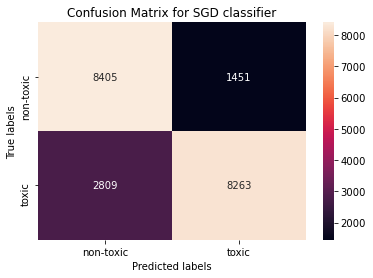

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
categories = ["non-toxic", "toxic"]
labels = [0,1]
cm = confusion_matrix(target_test, y_pred, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for SGD classifier'); 
ax.xaxis.set_ticklabels(categories); ax.yaxis.set_ticklabels(categories);

In [175]:
# printing index where actual target was True, but model predicted false
# for i in range(len(y_pred)):
#     if (target_test.iloc[i]) & (~y_pred[i]):
#         print(i)
    

In [165]:
# got 25th index as wrong prediction. Let's see what was the text 
X_test['comment_text'].iloc[25]

'Yes it was. \n\nFrom wiki:\n\n"In late 2015, Yiannopoulos began a campus speaking tour called "The Dangerous F*ggot Tour", encompassing universities in the United States and Great Britain. A number of his scheduled speeches in Great Britain were cancelled. Although most of his American speeches were not cancelled, some were met with notable protest ranging from vocal disruptions to cancellation via the heckler\'s veto. The journalist Audrey Goddard analysed his speech at the University of Pittsburgh. He concludes that Yiannopoulos spends the "majority of the time voicing his opinions with little to no factual statements accompanying them."\n\nIt should be noted that Yiannopoulos is a self-hating gay person who pines for conversion therapy but will say anything for a buck.'

#### Naive bayes training

In [27]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
nb = MultinomialNB()
nb.fit(tfidf_vectorizer_vectors, target_flag.values)

MultinomialNB()

In [29]:
y_pred_nb = nb.predict(X_test_tfidf_vector)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("accuracy ",accuracy_score(target_test, y_pred_nb))
print("F1 ",f1_score(target_test, y_pred_nb, average="macro"))
print("Precison ",precision_score(target_test, y_pred_nb, average="macro"))
print("Recall ",recall_score(target_test, y_pred_nb, average="macro")) 

accuracy  0.7446961009174312
F1  0.7377121011406861
Precison  0.7555724708386979
Recall  0.7377954093491593


## cleaning the text; adding idf=True

In [14]:
df_train.head()

,id,comment_text,severe_toxicity,comment_text_clean
4,59856,haha you guys are a bunch of losers.,0.021277,"[haha, guys, bunch, losers]"
5,59859,ur a sh*tty comment.,0.047619,"[ur, sh, tty, comment]"
6,59861,hahahahahahahahhha suck it.,0.050847,"[hahahahahahahahhha, suck]"
31,239607,Yet call out all Muslims for the acts of a few...,0.050000,"[yet, call, muslims, acts, get, pilloried, oka..."
34,239612,This bitch is nuts. Who would read a book by a...,0.107692,"[bitch, nuts, would, read, book, woman]"


In [13]:
import re
from nltk.corpus import stopwords
#removing punctuation
df_train['comment_text_clean'] = df_train.comment_text.apply(lambda x:re.sub(r'[^a-zA-z\s]', ' ', x.lower()))

#remove white spaces
df_train['comment_text_clean'] = df_train.comment_text_clean.apply(lambda x:re.sub(r'\s+', ' ', x))
stop = set(stopwords.words('english'))
df_train['comment_text_clean'] = df_train.comment_text_clean.apply(lambda x: [word for word in x.split() if word not in stop])


In [33]:
corpus = ["the house had a tiny little mouse", 
"the cat saw the mouse", 
"the mouse ran away from the house"]

In [34]:
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(corpus)

In [38]:
print(word_count_vector)

  (0, 9)	1
  (0, 4)	1
  (0, 3)	1
  (0, 10)	1
  (0, 5)	1
  (0, 6)	1
  (1, 9)	2
  (1, 6)	1
  (1, 1)	1
  (1, 8)	1
  (2, 9)	2
  (2, 4)	1
  (2, 6)	1
  (2, 7)	1
  (2, 0)	1
  (2, 2)	1


In [39]:
tv=TfidfVectorizer(smooth_idf=True, use_idf=False)
tv_vectors=tv.fit_transform(corpus)

In [40]:
tv.vocabulary_

{'the': 9,
 'house': 4,
 'had': 3,
 'tiny': 10,
 'little': 5,
 'mouse': 6,
 'cat': 1,
 'saw': 8,
 'ran': 7,
 'away': 0,
 'from': 2}

In [42]:
print(tv_vectors)

  (0, 9)	0.4082482904638631
  (0, 4)	0.4082482904638631
  (0, 3)	0.4082482904638631
  (0, 10)	0.4082482904638631
  (0, 5)	0.4082482904638631
  (0, 6)	0.4082482904638631
  (1, 9)	0.7559289460184544
  (1, 6)	0.3779644730092272
  (1, 1)	0.3779644730092272
  (1, 8)	0.3779644730092272
  (2, 9)	0.6666666666666666
  (2, 4)	0.3333333333333333
  (2, 6)	0.3333333333333333
  (2, 7)	0.3333333333333333
  (2, 0)	0.3333333333333333
  (2, 2)	0.3333333333333333


In [43]:
tv2=TfidfVectorizer(smooth_idf=True, use_idf=True)
tv_vectors2=tv2.fit_transform(corpus)

In [48]:
tv3=TfidfVectorizer(smooth_idf=True, use_idf=False, norm=None)
tv_vectors3=tv3.fit_transform(corpus)

In [44]:
print(tv_vectors2)

  (0, 6)	0.2856167584735664
  (0, 5)	0.4835912093301898
  (0, 10)	0.4835912093301898
  (0, 3)	0.4835912093301898
  (0, 4)	0.36778357947820167
  (0, 9)	0.2856167584735664
  (1, 8)	0.5168019428381698
  (1, 1)	0.5168019428381698
  (1, 6)	0.30523155268005514
  (1, 9)	0.6104631053601103
  (2, 2)	0.4334516694863821
  (2, 0)	0.4334516694863821
  (2, 7)	0.4334516694863821
  (2, 6)	0.25600353853646324
  (2, 4)	0.3296511670576223
  (2, 9)	0.5120070770729265


In [49]:
print(tv_vectors3)

  (0, 9)	1.0
  (0, 4)	1.0
  (0, 3)	1.0
  (0, 10)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (1, 9)	2.0
  (1, 6)	1.0
  (1, 1)	1.0
  (1, 8)	1.0
  (2, 9)	2.0
  (2, 4)	1.0
  (2, 6)	1.0
  (2, 7)	1.0
  (2, 0)	1.0
  (2, 2)	1.0


## Difference btw idf=False with cv is that : it normalized results of Count vectorizer to make norm 1 for a document; to make it equivalent to count vectorizer, use normalize=false in its constructor

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_train, test_size = 0.1)

In [62]:
X_train['comment_text_clean'] = X_train['comment_text_clean'].map(lambda x: (' ').join(x) )

<ipython-input-62-4a75b99a9d31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['comment_text_clean'] = X_train['comment_text_clean'].map(lambda x: (' ').join(x) )


In [68]:
X_test['comment_text_clean'] = X_test['comment_text_clean'].map(lambda x: (' ').join(x) )

<ipython-input-68-4921e9cf8ac8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['comment_text_clean'] = X_test['comment_text_clean'].map(lambda x: (' ').join(x) )


In [75]:
target_flag = X_train['severe_toxicity'] >0.0
target_test = X_test['severe_toxicity'] >0.0

In [64]:
tfidf=TfidfVectorizer(smooth_idf=True, use_idf=True) # smooth idf is to ensure that for test data, unseen words can be processed
tfidf_idfTrue=tfidf.fit_transform(X_train['comment_text_clean'])

In [76]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                    fit_intercept=True, max_iter=1000)
param_grid =  {'alpha': np.power(10, np.arange(-4, 2, dtype=float)),
              'loss':['hinge', 'log', 'modified_huber'],
              'penalty':['l2', 'l1', 'elasticnet'],
              'average': [True, False]}


grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(tfidf_idfTrue, target_flag.values)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

X_test_tfidf_vector = tfidf.transform(X_test['comment_text_clean'])
bestmodel = grid_search.best_estimator_
y_pred = bestmodel.predict(X_test_tfidf_vector)

#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("accuracy ",accuracy_score(target_test, y_pred))
print("F1 ",f1_score(target_test, y_pred, average="macro"))
print("Precison ",precision_score(target_test, y_pred, average="macro"))
print("Recall ",recall_score(target_test, y_pred, average="macro")) 


GridSearchCV took 200.04 seconds for 108 candidate parameter settings.
accuracy  0.799789755351682
F1  0.7997794696085989
Precison  0.8017672259670298
Recall  0.8022235913254346


/Users/preetika/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


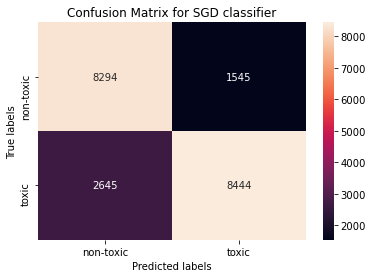

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
categories = ["non-toxic", "toxic"]
labels = [0,1]
cm = confusion_matrix(target_test, y_pred, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for SGD classifier'); 
ax.xaxis.set_ticklabels(categories); ax.yaxis.set_ticklabels(categories);

In [77]:
bestmodel.get_params()

{'alpha': 0.0001,
 'average': True,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'modified_huber',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [78]:
nb = MultinomialNB()
nb.fit(tfidf_idfTrue, target_flag.values)

y_pred_nb = nb.predict(X_test_tfidf_vector)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("accuracy ",accuracy_score(target_test, y_pred_nb))
print("F1 ",f1_score(target_test, y_pred_nb, average="macro"))
print("Precison ",precision_score(target_test, y_pred_nb, average="macro"))
print("Recall ",recall_score(target_test, y_pred_nb, average="macro")) 

accuracy  0.7458428899082569
F1  0.7412138451352779
Precison  0.7504487013432024
Recall  0.7404962570300955


### difference btw Hinge loss and huber loss

In [16]:
X_train, X_test = train_test_split(df_train, test_size = 0.1, random_state=44)


In [17]:
X_train['comment_text_clean'] = X_train['comment_text_clean'].map(lambda x: (' ').join(x) )
X_test['comment_text_clean'] = X_test['comment_text_clean'].map(lambda x: (' ').join(x) )

<ipython-input-17-310b1a7ebea9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['comment_text_clean'] = X_train['comment_text_clean'].map(lambda x: (' ').join(x) )
<ipython-input-17-310b1a7ebea9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['comment_text_clean'] = X_test['comment_text_clean'].map(lambda x: (' ').join(x) )


In [18]:
target_flag = X_train['severe_toxicity'] >0.0
target_test = X_test['severe_toxicity'] >0.0

In [19]:
tfidf=TfidfVectorizer(smooth_idf=True, use_idf=True) # smooth idf is to ensure that for test data, unseen words can be processed
tfidf_idfTrue=tfidf.fit_transform(X_train['comment_text_clean'])

In [21]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                    fit_intercept=True, max_iter=1000, alpha=0.0001, average=True)
clf.fit(tfidf_idfTrue, target_flag.values)

X_test_tfidf_vector = tfidf.transform(X_test['comment_text_clean'])
#bestmodel = grid_search.best_estimator_
y_pred_nb = clf.predict(X_test_tfidf_vector)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("accuracy ",accuracy_score(target_test, y_pred_nb))
print("F1 ",f1_score(target_test, y_pred_nb, average="macro"))
print("Precison ",precision_score(target_test, y_pred_nb, average="macro"))
print("Recall ",recall_score(target_test, y_pred_nb, average="macro")) 

accuracy  0.7879873853211009
F1  0.7877368453968405
Precison  0.7947417555914659
Recall  0.7914149762174425


In [22]:
clf = SGDClassifier(loss='modified_huber', penalty='l2',
                    fit_intercept=True, max_iter=1000, alpha=0.0001, average=True)
clf.fit(tfidf_idfTrue, target_flag.values)

X_test_tfidf_vector = tfidf.transform(X_test['comment_text_clean'])
#bestmodel = grid_search.best_estimator_
y_pred_nb = clf.predict(X_test_tfidf_vector)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("accuracy ",accuracy_score(target_test, y_pred_nb))
print("F1 ",f1_score(target_test, y_pred_nb, average="macro"))
print("Precison ",precision_score(target_test, y_pred_nb, average="macro"))
print("Recall ",recall_score(target_test, y_pred_nb, average="macro")) 

accuracy  0.8048069571865444
F1  0.804806528901192
Precison  0.8064793832075156
Recall  0.8065633059353087
